# Implementando GloVe

## Implementando com a mesma arquitetura do modelo SE3M

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,Bidirectional,Dropout
from keras.layers import AveragePooling1D
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.layers import Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.metrics import * 
from sklearn.model_selection import KFold 
import os


2024-08-01 22:43:02.807374: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 22:43:04.653016: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 22:43:04.653097: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 22:43:04.658903: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 22:43:05.437373: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-01 22:43:12.777148: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer

In [4]:
df = pd.read_csv('reqTxt.csv', header=None) #Report or file containing the set of training and test texts.

In [5]:
df

,0
0,add ca against object literals in function inv...
1,update branding for appcelerator plugin to app...
2,create new json schema for sdk teamcreate json...
3,create project references property pagecreate ...
4,new desktop project wizarddesktop need to conv...
...,...
23308,introduce datastax java driver in effort to mi...
23309,simplify central sso eliminate ext token valid...
23310,proof of concept use akka for unique value enf...
23311,set a property to turn off usergrids dependenc...


In [6]:
dfRequire = df.iloc[:,:] 

In [7]:
print(dfRequire.shape)
print(dfRequire.columns)
X = dfRequire[0]
print(X[0])
X = np.array(X)

print(len(X))

print('Train and test dataset loaded...')

(23313, 1)
Int64Index([0], dtype='int64')
add ca against object literals in function invocationsthe idea here is that if our metadata captures a type as function arg we should be able to create an instance of that type as an object literal as an arg to a function invocation for examplep    tiuicreatelabel  ltpropertycaheregt  code prediv
23313
Train and test dataset loaded...


In [8]:
y = pd.read_csv('estiDeep.data', header=None) #File containing the set of training and test labels.
y = np.array(y)
print ('Shape of label tensor:', y.shape)
print(y.dtype)

Shape of label tensor: (23313, 1)
int64


In [9]:
#Number of texts in train and test dataset 
MAX_LEN = 23313

kf = KFold(n_splits=10, shuffle=True, random_state=1000) 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 

KFold(n_splits=10, random_state=1000, shuffle=True)


In [20]:
pip install tensorflow-hub

Note: you may need to restart the kernel to use updated packages.


In [10]:
token = Tokenizer()
token.fit_on_texts(X)
seq = token.texts_to_sequences(X)

In [11]:
pad_seq = pad_sequences(seq,maxlen=100)

In [12]:
vocab_size = len(token.word_index)+1

In [13]:
from tqdm import tqdm
embedding_vector = {}
f = open(os.path.join('GloVe/glove.6B.300d.txt'))
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

400000it [00:31, 12616.46it/s]


In [14]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 96952/96952 [00:00<00:00, 400319.51it/s]


In [15]:
vetMAE = []
vetR2 = []
vetMSE = []
vetMdae = []

i = 0

for train_index, test_index in kf.split(X):

    x_train, test_x = X[train_index], X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    
    # get the raw text data
    texts_train = x_train.astype(str)
    texts_test = test_x.astype(str)
    # vectorize the text samples                                   
    tokenizer = Tokenizer(num_words = MAX_LEN, char_level=False, lower=False) 
    tokenizer.fit_on_texts(texts_train)                            
    encSequences = tokenizer.texts_to_sequences(texts_train)          
    encSequences_test = tokenizer.texts_to_sequences(texts_test)      

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    #vocab_size = len(tokenizer.word_index) + 1 
    print('Vocab_size: '+ str(vocab_size))

    MAX_SEQUENCE_LENGTH = 300 #number of words in each text

    x_train = pad_sequences(encSequences, maxlen= MAX_SEQUENCE_LENGTH, padding='post')
    x_test = pad_sequences(encSequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    print('Shape of data tensor:', x_train.shape)
    print('Shape of data test tensor:', x_test.shape)

    print('train_y: ' + str(train_y.shape))
    print('test_y: ' + str(test_y.shape))


    #Sequential model
    model = Sequential()
    
    model.add(Embedding(vocab_size,300,weights = [embedding_matrix],input_length=300,trainable = False))
    
    model.add(AveragePooling1D(pool_size=300))
    
    print(model.output_shape)
    
    #Enable this line for the model with LSTM
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=False)) 
    
    #Disable the line below for the model with the LSTM layer 
    #model.add(Flatten()) 
    
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = Adam(lr = 0.001, beta_1 = 0.99, beta_2 = 0.999, epsilon = None, amsgrad = False)

    model.compile(loss = 'mse', optimizer= 'adam', metrics=['mae'])

    model.summary()

    print('Modelo compilado...')

    es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=10, restore_best_weights=True)

    model_history = model.fit(x_train, train_y,
              batch_size= 128,
              epochs=30, callbacks=[es],
              validation_data=(x_test, test_y))                

    y_pred = model.predict(x_test, batch_size=None, verbose=0, steps=None)
    x_pred = model.predict(x_train, batch_size=None, verbose=0, steps=None)


    #Metrics
    print("\n")
    mae = mean_absolute_error(test_y, y_pred)
    vetMAE.append(mae)
    print("MAE: %f" % (mae))
    medAE = median_absolute_error(test_y, y_pred)
    vetMdae.append(medAE)
    print("MedAE: %f" % (medAE))
    r2 = r2_score(test_y, y_pred, multioutput='raw_values')
    vetR2.append(r2)
    print("r2: %f" % (r2))
    mse = mean_squared_error(test_y, y_pred)
    vetMSE.append(mse)
    print("MSE: %f" % (mse))
    mErr = max_error(test_y, y_pred)
    print("maxrror: %f" % (mErr))

    i = i + 1
    print("Concluido " + str(i))




Found 89802 unique tokens.
Vocab_size: 96953
Shape of data tensor: (20981, 300)
Shape of data test tensor: (2332, 300)
train_y: (20981, 1)
test_y: (2332, 1)
(None, 1, 300)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          29085900  
                                                                 
 average_pooling1d (Average  (None, 1, 300)            0         
 Pooling1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                        

(None, 1, 300)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          29085900  
                                                                 
 average_pooling1d_1 (Avera  (None, 1, 300)            0         
 gePooling1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 50)                70200     
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                       

(None, 1, 300)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          29085900  
                                                                 
 average_pooling1d_2 (Avera  (None, 1, 300)            0         
 gePooling1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 50)                70200     
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 10)                510       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                       

(None, 1, 300)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 300)          29085900  
                                                                 
 average_pooling1d_3 (Avera  (None, 1, 300)            0         
 gePooling1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 50)                70200     
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 10)                510       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                       

(None, 1, 300)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 300)          29085900  
                                                                 
 average_pooling1d_4 (Avera  (None, 1, 300)            0         
 gePooling1D)                                                    
                                                                 
 lstm_4 (LSTM)               (None, 50)                70200     
                                                                 
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dense_13 (Dense)            (None, 10)                510       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                       

(None, 1, 300)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 300)          29085900  
                                                                 
 average_pooling1d_5 (Avera  (None, 1, 300)            0         
 gePooling1D)                                                    
                                                                 
 lstm_5 (LSTM)               (None, 50)                70200     
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 10)                510       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                       

(None, 1, 300)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 300, 300)          29085900  
                                                                 
 average_pooling1d_6 (Avera  (None, 1, 300)            0         
 gePooling1D)                                                    
                                                                 
 lstm_6 (LSTM)               (None, 50)                70200     
                                                                 
 dense_18 (Dense)            (None, 50)                2550      
                                                                 
 dense_19 (Dense)            (None, 10)                510       
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                       

(None, 1, 300)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 300, 300)          29085900  
                                                                 
 average_pooling1d_7 (Avera  (None, 1, 300)            0         
 gePooling1D)                                                    
                                                                 
 lstm_7 (LSTM)               (None, 50)                70200     
                                                                 
 dense_21 (Dense)            (None, 50)                2550      
                                                                 
 dense_22 (Dense)            (None, 10)                510       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                       

(None, 1, 300)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 300, 300)          29085900  
                                                                 
 average_pooling1d_8 (Avera  (None, 1, 300)            0         
 gePooling1D)                                                    
                                                                 
 lstm_8 (LSTM)               (None, 50)                70200     
                                                                 
 dense_24 (Dense)            (None, 50)                2550      
                                                                 
 dense_25 (Dense)            (None, 10)                510       
                                                                 
 dense_26 (Dense)            (None, 1)                 11        
                                       

(None, 1, 300)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 300, 300)          29085900  
                                                                 
 average_pooling1d_9 (Avera  (None, 1, 300)            0         
 gePooling1D)                                                    
                                                                 
 lstm_9 (LSTM)               (None, 50)                70200     
                                                                 
 dense_27 (Dense)            (None, 50)                2550      
                                                                 
 dense_28 (Dense)            (None, 10)                510       
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                       

In [16]:

maeMedio = np.mean(vetMAE)  
madAEMedio = np.mean(vetMdae)  
r2Medio = np.mean(vetR2)  
mseMedio = np.mean(vetMSE) 
stdMae = np.std(vetMAE)
stdr2 = np.std(vetR2)
stdMse = np.std(vetMSE)

In [17]:
print('maeMedio: ' + str(maeMedio))
print('madAEMedio: ' + str(madAEMedio))
print('r2Medio: ' + str(r2Medio))
print('mseMedio: ' + str(mseMedio))
print('stdMae: ' + str(stdMae))
print('stdr2: ' + str(stdr2))
print('stdMse: ' + str(stdMse))

maeMedio: 4.549541827277139
madAEMedio: 2.87524573802948
r2Medio: 0.01912670061722177
mseMedio: 98.02318797246164
stdMae: 0.187942159207074
stdr2: 0.046368730743290384
stdMse: 9.08577432730454


In [57]:
y_pred

array([[5.4082985],
       [4.6896725],
       [4.933695 ],
       ...,
       [6.0474453],
       [4.0168257],
       [5.9728684]], dtype=float32)

In [22]:
Ytest_ = model.predict(x_test)

73/73 [==============================] - 1s 8ms/step


In [18]:
def calcular_estatisticas(vetor, nome):
    minimo = np.min(vetor)
    maximo = np.max(vetor)
    media = np.mean(vetor)
    print(f"{nome} - Min: {minimo}, Max: {maximo}, Média: {media}")

# Exibindo as estatísticas para cada métrica
calcular_estatisticas(vetMAE, "MAE")
calcular_estatisticas(vetMdae, "MedAE")
calcular_estatisticas(vetR2, "R2")
calcular_estatisticas(vetMSE, "MSE")


MAE - Min: 4.144141502617664, Max: 4.792056991211696, Média: 4.549541827277139
MedAE - Min: 2.1240153312683105, Max: 3.2041966915130615, Média: 2.87524573802948
R2 - Min: -0.04141464058328048, Max: 0.09306307362604538, Média: 0.01912670061722177
MSE - Min: 80.31874340268091, Max: 109.40815017075299, Média: 98.02318797246164


In [ ]:
vetMAE.min

### Gerando o gráfico de perda

In [19]:
import matplotlib.pyplot as plt

In [31]:
model_history

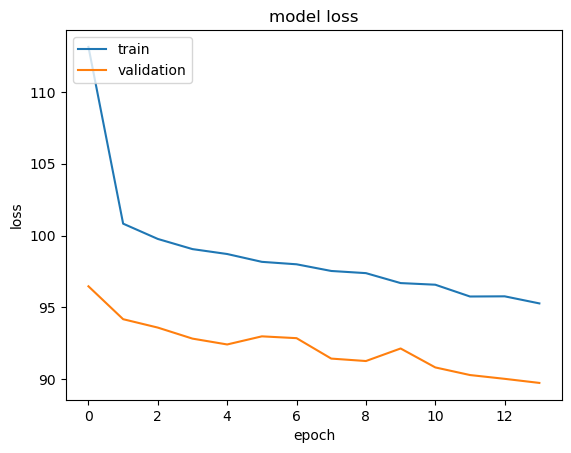

In [20]:
# "Loss"
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Implementando o teste wilcoxon

In [26]:
from scipy.stats import wilcoxon# Realizando o teste de Wilcoxon
statistic, p_value = wilcoxon(test_y, y_pred)

# Imprimindo o valor estatístico e o valor p
print("Estatística do teste:", statistic)
print("Valor p:", p_value)

Estatística do teste: [862777.]
Valor p: [1.24368054e-52]


In [28]:
#avaliando o MAE dos dois modelos 
glove = [4.79, 4.14]
bert = [4.52, 0.09]
# Realizando o teste de Wilcoxon
statistic, p_value = wilcoxon(glove, bert)

# Imprimindo o valor estatístico e o valor p
print("Estatística do teste:", statistic)
print("Valor p:", p_value)

Estatística do teste: 0.0
Valor p: 0.5


Analyzing the statistics regarding the evaluation metrics of the two models compared here, BERT and GloVe, it is possible to conclude that there is no significant difference between the two samples, thus proving that the results of the two models are very similar.

